# Разработка A/B-тестирования и анализ результатов


## Введение


**Цель**: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

**Задачи:**  
1. Загрузить и исследовать исторические данные.  
2. Определить целевую метрику и рассчитать параметры теста — размер выборки, длительность и мощность.  
3. Проверить корректность распределения пользователей по группам и независимость выборок.  
4. Провести анализ результатов A/B-теста и оценить статистическую значимость различий.  
5. Сделать выводы и дать рекомендации по внедрению изменений.

**Описание данных**

Используются три таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. 

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. 

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

**Содержание проекта**

1. Введение
2. EDA и анализ исторических данных
3. Планирование эксперимента
4. Мониторинг и корректность теста
5. Проверка результатов

### Работа с историческими данными (EDA)

#### Загрузка исторических данных

Изучим исторические данные приложения:

Импортируем библиотеки.

Считаем и сохраним в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

In [1]:
# Импорт библоиотек
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Сохраняем данеые в датафрейм session_history
sessions_history = pd.read_csv("D:\sessions_project_history.csv")

# Выводим первые 5 строк
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### Знакомство с данными

In [3]:
# Рассчитываем количество сессия для каждого пользователя
sessions_history.groupby('user_id')['session_id'].count().reset_index()

,user_id,session_id
0,00005FB6A13A6FBE,2
1,0000B15A18D77ED9,3
2,0000C4E3A4A571A9,2
3,000293FAF9E67A81,4
4,00029C5AE889A6C3,2
...,...,...
134034,FFFCDE7746148710,4
134035,FFFDD413285E753F,3
134036,FFFECBA0F2578AB0,2
134037,FFFEDB68228B5F21,5


In [4]:
# Выводим все данные о пользователе с наибольшим количеством посещений
sessions_history[sessions_history['user_id'] == sessions_history.groupby('user_id')['session_id'].count().idxmax()]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### Анализ числа регистраций

Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, посмотрим, как менялось число регистраций в приложении за время его существования.

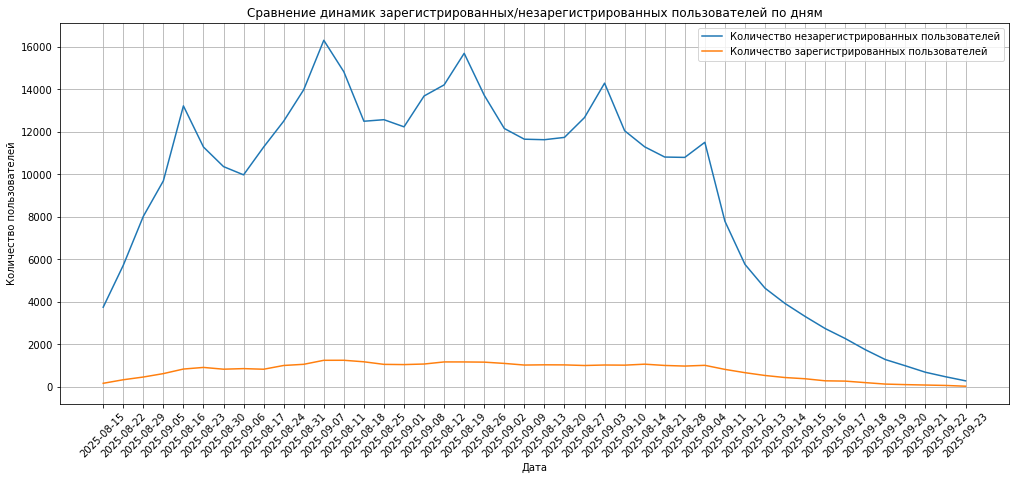

In [5]:
# Считаем количество уникальных незарегистрированных пользователей по дням
unregistrated_users_count = sessions_history[sessions_history['registration_flag'] == 0].groupby('session_date')['user_id'].nunique()

# Считаем количество уникальных зарегистрированных пользователей по дням
registrated_users_count = sessions_history[sessions_history['registration_flag'] == 1].groupby('session_date')['user_id'].nunique()

# Задаем размер графика
plt.figure(figsize = (17, 7))

# Строим графики количества уникальных пользователей по дням
plt.plot(sessions_history['session_date'].unique(), unregistrated_users_count, label = 'Количество незарегистрированных пользователей')
plt.plot(sessions_history['session_date'].unique(), registrated_users_count, label = 'Количество зарегистрированных пользователей')

# Настраиваем оформление графика
plt.legend()
plt.xticks(rotation = 45)
plt.grid()
plt.title('Сравнение динамик зарегистрированных/незарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.show()

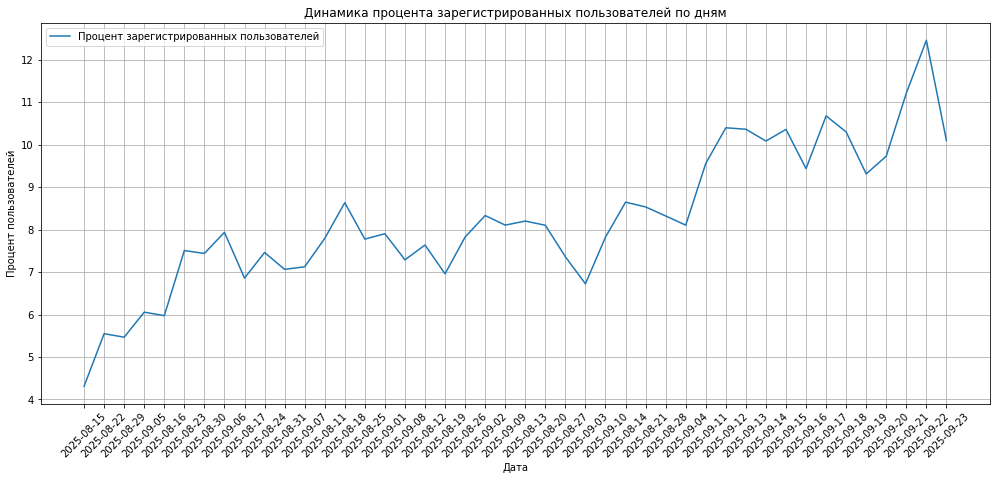

In [6]:
# Считаем долю уникальных зарегистрированных пользователей по дням
registrated_part = sessions_history[sessions_history['registration_flag'] == 1].groupby('session_date')['user_id'].nunique() / sessions_history.groupby('session_date')['user_id'].nunique() * 100

# Задаем размер графика
plt.figure(figsize = (17, 7))

# Строим график процента уникальных пользователей по дням
plt.plot(sessions_history['session_date'].unique(), registrated_part, label = 'Процент зарегистрированных пользователей')

# Настраиваем оформление графика
plt.legend()
plt.xticks(rotation = 45)
plt.grid()
plt.title('Динамика процента зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Процент пользователей')
plt.show()

#### Анализ числа просмотренных страниц

Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

In [7]:
# Рассчитываем количество сессий в зависимости от числа просмотренных страниц
sessions_count = sessions_history.groupby('page_counter')['session_id'].nunique().reset_index()

print(sessions_count)

   page_counter  session_id
0             1       29160
1             2      105536
2             3      166690
3             4      105569
4             5       26288
5             6        2589
6             7          92


<AxesSubplot:title={'center':'Количество сессий в зависимости от количества просмотренных страниц'}, xlabel='Количество просмотренных страниц', ylabel='Количество сессий'>

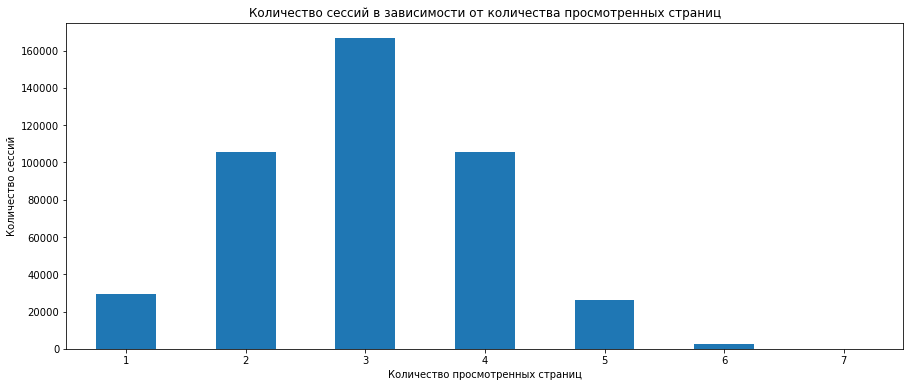

In [8]:
# Строим столбчатую диаграмму по количеству просмотренных страниц
sessions_count.plot(
    kind = 'bar',
    x = 'page_counter',
    y = 'session_id',
    rot = 0,
    legend = False,
    xlabel = 'Количество просмотренных страниц',
    ylabel = 'Количество сессий',
    title = 'Количество сессий в зависимости от количества просмотренных страниц',
    figsize = (15, 6)
)

#### Доля пользователей, просмотревших более четырёх страниц


In [9]:
# В столбец good_session записываем 0, если просмотрено менее 4 страниц, иначе 1
sessions_history['good_session'] = 0
sessions_history.loc[sessions_history['page_counter'] >= 4, 'good_session'] = 1

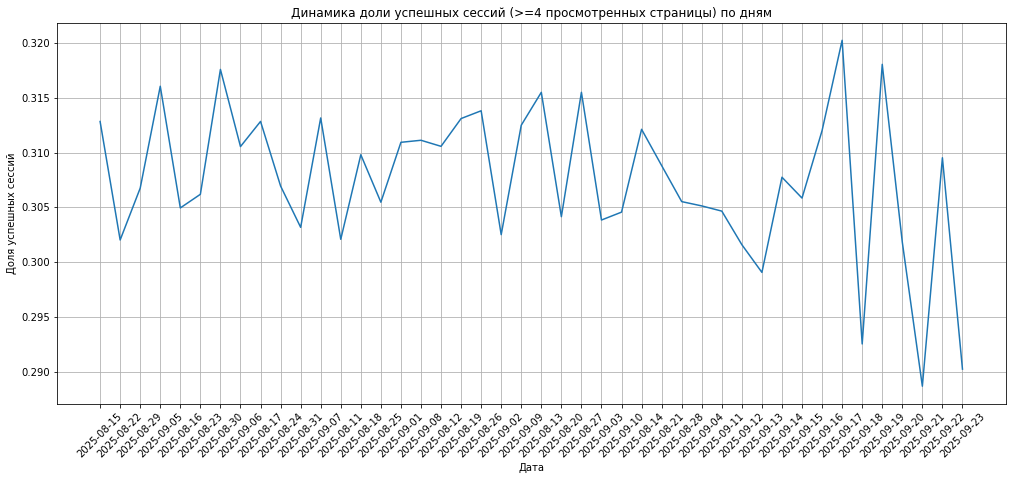

In [10]:
# Считаем успешных сессий по дням
good_session_part = sessions_history.groupby('session_date')['good_session'].mean()

# Задаем размер графика
plt.figure(figsize = (17, 7))

# Строим график доли успешных сессий по дням
plt.plot(sessions_history['session_date'].unique(), good_session_part)

# Настраиваем оформление графика
plt.xticks(rotation = 45)
plt.grid()
plt.title('Динамика доли успешных сессий (>=4 просмотренных страницы) по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.show()

### 2. Подготовка к тесту

При планировании теста проделаем несколько важных шагов:

- Сформулируем нулевую и альтернативную гипотезы

- Определимся с целевой метрикой.

- Рассчитаем необходимый размер выборки.

- Исходя из текущих значений трафика рассчитаем необходимую длительность проведения теста.

#### Формулировка нулевой и альтернативной гипотез


**Ключевая метрика** - доля успешных сессий, где успешной считается сессия, в которой было просмотренно 4 и более страницы.

**Нулевая гипотеза(Н0)**: Доля успешных сессий в группе с новым алгоритмом равна доле успешных сессий в контрольной группе.

**Альтернативная гипотеза(Н1)**: Доля успешных сессий в группе с новым алгоритмом превышает долю успешных сессий в контрольной группе более чем на 3%.

#### Расчёт размера выборки

Используем следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. 

In [11]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import numpy as np

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03   # Минимальный детектируемый эффект
p1 = p + mde
effect_size = (p1 - p) / np.sqrt((p*(1-p) + p1*(1-p1))/2)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3759


#### Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста, разделив одно на другое.

In [12]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round(sessions_history.groupby('session_date')['user_id'].nunique().mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 1 дней


### Мониторинг А/В-теста

#### Проверка распределения пользователей

In [13]:
# Сохраняем данные в датафрейм sessions_test_part
sessions_test_part = pd.read_csv("D:\sessions_project_test_part.csv")

In [14]:
# Рассчитываем количество уникальных пользователей в каждой группе 
users_in_test_groups = sessions_test_part.groupby('test_group')['user_id'].nunique().T

# Считаем процентную разницу в количестве пользователей разаных групп
p = abs(users_in_test_groups['A'] - users_in_test_groups['B']) / users_in_test_groups['A'] * 100

print(f'Процентная разница в количестве пользователей в группах A и B за первый день эксперимента: {round(p, 4)}%')

Процентная разница в количестве пользователей в группах A и B за первый день эксперимента: 0.7448%


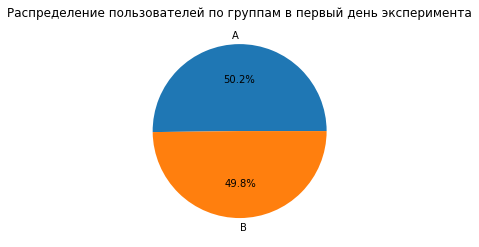

In [15]:
# Строим круговую диаграмму
plt.pie([users_in_test_groups['A'], users_in_test_groups['B']], labels = ['A', 'B'], autopct = '%1.1f%%')

plt.title('Распределение пользователей по группам в первый день эксперимента')
plt.show()

#### Проверка пересечений пользователей

Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

In [16]:
# Создаем отдельные датафреймы для каждой группы
group_A = sessions_test_part[sessions_test_part.test_group == 'A']
group_B = sessions_test_part[sessions_test_part.test_group == 'B']

# Создаём список пересечений уникальных пользоваталей между двумя группами
list(set(group_A['user_id']) & set(group_B['user_id']))

[]

Нет пользователей, которые встречаются одновременнно в двух группах.

#### Равномерность разделения пользователей по устройствам

Также убедимся в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Text(0.5, 0.98, 'Распределение пользователей по устройствам в первый день эксперимента')

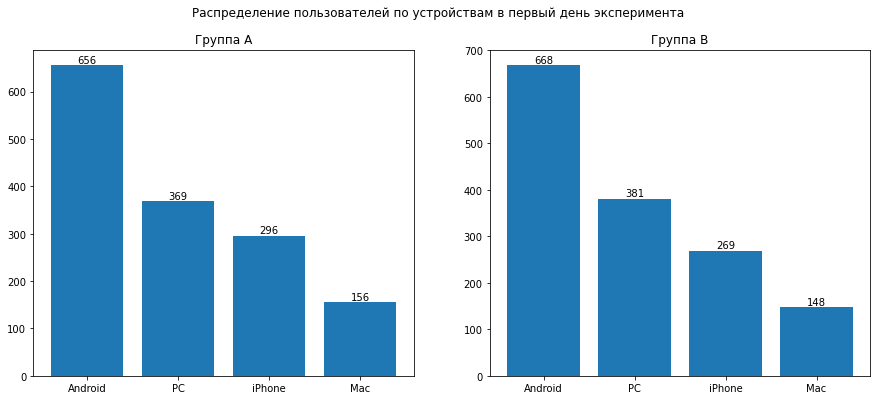

In [17]:
# Создаём датафреймы, содержащие информацию о количестве пользоваталей для каждого типа устройства в первый день
group_A_devices = group_A.groupby('device')['user_id'].nunique().reset_index().sort_values(by = 'user_id', ascending = False)
group_B_devices = group_B.groupby('device')['user_id'].nunique().reset_index().sort_values(by = 'user_id', ascending = False)

# Создаём область для нескольких графиков в одной фигуре
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Столбчатая диаграмма для группы A
ax1.bar(group_A_devices['device'], group_A_devices['user_id'])
ax1.set_title('Группа A')

# Столбчатая диаграмма для группы B
ax2.bar(group_B_devices['device'], group_B_devices['user_id'])
ax2.set_title('Группа B')

# Добавляем подписи значений на каждый график
for i, value in enumerate(group_A_devices['user_id']):
    ax1.text(i, value, str(value), ha='center', va='bottom')
    
for i, value in enumerate(group_B_devices['user_id']):
    ax2.text(i, value, str(value), ha='center', va='bottom')

# Заголовок всей фигуры
plt.suptitle('Распределение пользователей по устройствам в первый день эксперимента')

#### Равномерность распределения пользователей по регионам

Проверим, что пользователи равномерно распределены по регионам.

Text(0.5, 0.98, 'Распределение пользователей по регионам в первый день эксперимента')

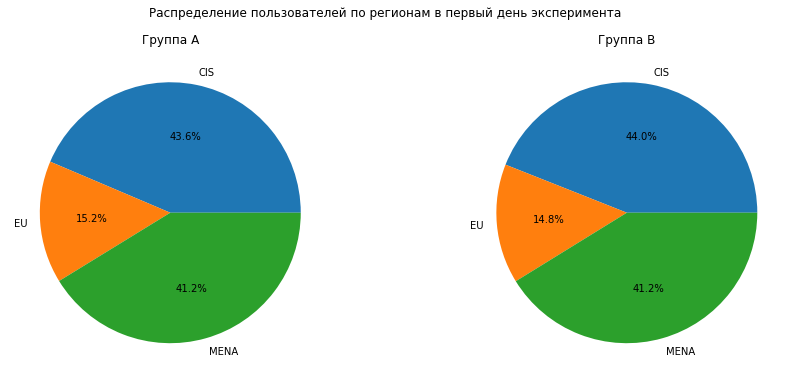

In [18]:
# Создаём датафреймы, содержащие информацию о количестве пользоваталей для каждого региона в первый день
group_A_regions = group_A.groupby('region')['user_id'].nunique().reset_index()
group_B_regions = group_B.groupby('region')['user_id'].nunique().reset_index()

# Создаём область для нескольких графиков в одной фигуре
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Круговая диаграмма для группы A
ax1.pie(group_A_regions['user_id'], labels = group_A_regions['region'], autopct = '%1.1f%%')
ax1.set_title('Группа A')

# Круговая диаграмма для группы B
ax2.pie(group_B_regions['user_id'], labels = group_B_regions['region'], autopct = '%1.1f%%')
ax2.set_title('Группа B')

# Заголовок всей фигуры
plt.suptitle('Распределение пользователей по регионам в первый день эксперимента')

#### Вывод после проверки A/B-теста

Разница в количестве пользователей между группами за первый день: **0.7448%** - по числу пользователей группы распределены практически равномерно.

Пересечения пользователей между группами не обнаружено - выборки являются **независимыми**.

**Распределения** по категориальным переменным - устройствам и регионам - **схожи**: существенных отклонений не выявлено.

Тест проходит **корректно**: группы по объёму почти равны, пересечений пользователей нет, регионы и устройства распределены ровно.

### Проверка результатов A/B-теста


In [19]:
# Сохраняем данные в датафрейм sessions_test
sessions_test = pd.read_csv("D:\sessions_project_test.csv")

# В столбец good_session записываем 0, если просмотрено менее 4 страниц, иначе 1
sessions_test['good_session'] = 0
sessions_test.loc[sessions_test['page_counter'] >= 4, 'good_session'] = 1

#### Проверка корректности результатов теста


Убедимся, что тест проведён корректно и будут сравниваться две сопоставимые группы. Для проверки равенства двух групп используем **t-test**.

**Нулевая гипотеза(Н0)**: Среднее количество уникальных дневных сессий в группе A и группе B не различается.

**Альтернативная гипотеза(Н1)**: Среднее количество уникальных дневных сессий в группе A и группе B различается.

In [20]:
# Оставляем только данные во время эксперимента
#sessions_test = sessions_test[(sessions_test['session_date'] >= '2025-10-14') & (sessions_test['session_date'] <= '2025-10-22')]

# Рассчитываем количество уникальных сессий по дням для каждой группы
metric_a = sessions_test[sessions_test.test_group == 'A'].groupby('session_date')['session_id'].nunique()
metric_b = sessions_test[sessions_test.test_group == 'B'].groupby('session_date')['session_id'].nunique()

# t-test
stat_ttest, p_value_ttest = ttest_ind(
        metric_a,
        metric_b
)

# Задаём уровень значимости
alpha = 0.05

# Интерпретируем полученные значения
if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента = {round(p_value_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение - выборочные средние в группах A и B равны')
    print('Количество уникальных дневных сессий в двух группах не различаются или различия не статистически значимы')
else:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения - выборочные средние в группах A и B не равны')
    print('Количество уникальных дневных сессий в двух группах различаются')

p-value теста Стьюдента = 0.94
Нулевая гипотеза находит подтверждение - выборочные средние в группах A и B равны
Количество уникальных дневных сессий в двух группах не различаются или различия не статистически значимы


#### Сравнение доли успешных сессий

In [21]:
# Рассчитываем процент успешных сессий
good_sessions_test = sessions_test.groupby('test_group')['good_session'].mean() * 100

print(f'Доля успешных сессий в группе A: {round(good_sessions_test.A, 2)}%')
print(f'Доля успешных сессий в группе B: {round(good_sessions_test.B, 2)}%')
print(f'Доля успешных сессий (>= 4 просмотренных страниц) в группе B  больше значения группы A на {round(good_sessions_test.B - good_sessions_test.A, 2)}%')

Доля успешных сессий в группе A: 30.77%
Доля успешных сессий в группе B: 31.83%
Доля успешных сессий (>= 4 просмотренных страниц) в группе B  больше значения группы A на 1.06%


#### Насколько статистически значимо изменение ключевой метрики

Используем **z-тест** для определения статистической значимости полученных результатов.

**Нулевая гипотеза(Н0)**: Доля успешных сессий в тестовой группе равна доле успешных сессий в контрольной группе.

**Альтернативная гипотеза(Н1)**: Доля успешных сессий в тестовой группе значимо превышает долю успешных сессий в контрольной группе.

In [22]:
n_a, n_b = sessions_test[sessions_test.test_group == 'A'].shape[0], sessions_test[sessions_test.test_group == 'B'].shape[0]
                                                                                  
m_a = sessions_test[(sessions_test.test_group == 'A')&(sessions_test.good_session==1)].shape[0]
m_b = sessions_test[(sessions_test.test_group == 'B')&(sessions_test.good_session==1)].shape[0]
                                                                                  
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Доля успешных сессий в тестовой группе равна доле успешных сессий в контрольной группе.')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Доля успешных сессий в тестовой группе значимо превышает долю успешных сессий в контрольной группе')                                                                           

pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения!
Доля успешных сессий в тестовой группе значимо превышает долю успешных сессий в контрольной группе


####  Вывод по результатам A/B-эксперимента

**Цель** A/B-эксперимента: оценка влияния нового алгоритма рекомендаций на количество успешных сессий (более 3 просмотренных страниц).
Всего в эксперименте участвовало **82 080 пользователей** (по 41 040 в каждой группе). Длительность эксперимента составила **20 дней**. Распределение по группам прошло корректно и **равномерно**.

Доля успешных сессий (>= 4 просмотренных страниц) в группе B  больше значения группы A на 1.06%. Иначе говоря, доля успешных сессий **улучшилась на 3.45%** относительно прежнего уровня.

Для сравнения долей использовался z-тест. Полученное значение **p-value = 0.00016**, что значительно меньше уровня значимости 0.05.
Нулевая гипотеза отвергается - **доля** успешных сессий в тестовой группе **значимо выше**, чем в контрольной.

Новый алгоритм рекомендаций **положительно влияет** на ключевую метрику - доля успешных сессий **выросла** более чем на 1% и эффект статистически значим. **Рекомендуется внедрить** новый алгоритм рекомендаций в приложение.